# 2: Model evaluation and selection

Eva Dyer, BMED 6517

___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A model is parametrized by a set of "parameters" $\beta$. To fit a model to data means to find the right model parameters for a given set of data.


This is achieved through numerical and/or analytical optimization of a "loss function" or "objective function" ($L(\beta)$). This function defines the quality of the model.

### 1. Loss functions


Simple loss functions include:

* Sum of squared error (least-squares regression)
* Sum of squared error plus size of parameters (regularization)
* Other norms or metrics


In [2]:
y = np.random.rand(8)
yhat = np.random.rand(8)

In [3]:
SSE = sum((y - yhat)**2)
MSE = SSE/len(y)
print('Sum of squared error =', SSE)
print('Mean squared error=', MSE)

Sum of squared error = 0.9908217839316766
Mean squared error= 0.12385272299145958


Example: Least-squares regression

$$\min_{\beta}~~\| y - {\bf X} \beta \|_2^2$$

Let's go to the board!

**Challenge:**

1. Write out the closed-form expression for the least-squares estimator below
2. Bonus points if you can write out the entire derivation that we went through in class.

Answer:

>



### 2. Numerical optimization
Optimization (finding minima or maxima of a function) is a large field in mathematics, and optimization of complicated functions can be rather involved. Here we will only look at a few very simple cases.

For a more detailed introduction to optimization with SciPy see: https://scipy-lectures.org/advanced/mathematical_optimization/

#### Example 1: Finding a function's minimum

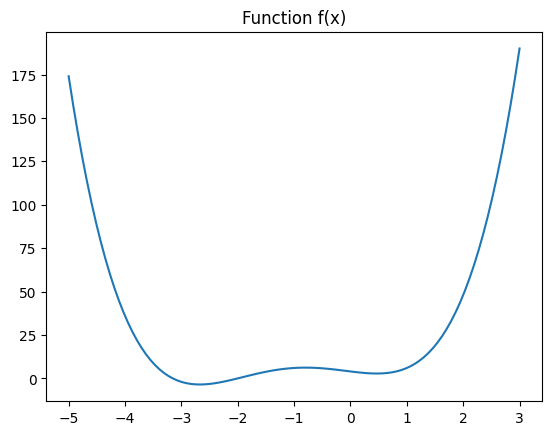

In [4]:
def f(x):
    return 4*x**3 + (x-2)**2 + x**4

x = np.linspace(-5, 3, 100)
plt.plot(x, f(x))
plt.title('Function f(x)')
plt.show()

The goal is to find the minimum of f(x).

There are many types of optimizers available. If you are interested, you can read more in the [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [5]:
from  scipy.optimize  import minimize

x_min = minimize(f, -4)
print('The minimum is:', x_min.x)

The minimum is: [-2.67298162]


What happens if we start at a different initial point?

#### Example 2: Solving an equation
A related problem is solving an equation, which can be achieved with the `fsolve` function.

Here we want to find `x` such that `g(x)=0`

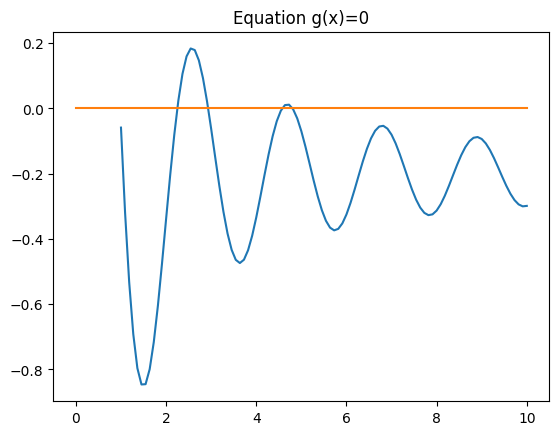

In [6]:
def g(x):
    return np.sin(3*x)*(1/x) - 0.2

x = np.linspace(1, 10, 100)
plt.plot(x, g(x))
plt.plot([0,10],[0,0])
plt.title('Equation g(x)=0')
plt.show()

In [7]:
from scipy.optimize import fsolve

ans = fsolve(g, 3)
print('The solution is:', ans)

The solution is: [2.93266852]


### 3. Model evaluation

Let's consider a simple binary classification task: Given a set of $N$ data points $\{x_i, y_i\}$ with $x_i \in \mathbb{R}$ and $y_i \in \{0,1\}$. The goal is to select a model and fit it to the data to minimize a classification loss function.

An easy way of achieveing minimal training loss is to memorize all the training samples in the $\bf{W}$ parameters. If the model can correctly classify all the training examples perfectly then we can achieve minimal training loss.

However, this is not our ultimate goal. The goal is to have a model that will **generalize to new examples** not seen during training.

One way to achieve this goal is through "cross-validation", where some examples ("validation" examples) are hidden when the model is fit to "training" examples, and the loss function is assessed on the hidden validation samples.


#### 3.1. Cross-validation strategies

There are many strategies for cross-validation:

* *hold-out*: randomly leave out a percentage (usually ~30%) of the data during training.
* *k-fold*: select `k` (usually 3-5) randomly-assigned sub-groups of data, and train `k` times holding each group out.
* *leave p-out*: leave `p` (usually 1) samples out of the training and assess the error for the `p` that were left out. Repeat for all possible `p` subsets of the sample.
* *stratified splitting (or stratified k-fold)*: maintains class proportions across the train/test splits.

Cross-validation is used to determine hyperparameters. In this case, even the "test" sets are used to optimize the model. It is common to select an additional "validation" or "holdout" subset for a final validation of the model.

Important (and often violated) assumption: **The collected data is representative of future data.**

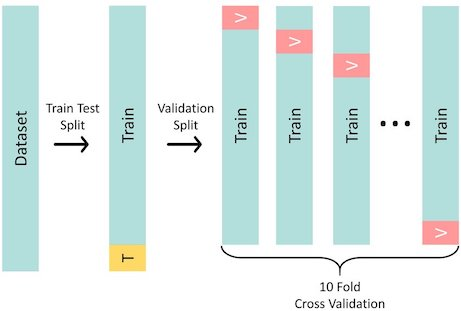

See this [sklearn tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) with many examples of splitting strategies for defining training, test, and validation sets!

#### 3.2. Example

##### **1) Generate Dataset**

Let's consider the following function
$$f(x) = \cos(\frac{3}{2} \pi x) + \varepsilon, \forall x \in [0,1]$$
where $\varepsilon \sim \mathcal{N}(0,\sigma^2)$ is drawn from a Gaussian distribution with mean $0$ and variance $\sigma^2$.

Given $n$ samples $(x_i, y_i)$ with $y_i=f(x_i)$, the goal is to find an approximation $\hat f$ of $f$.

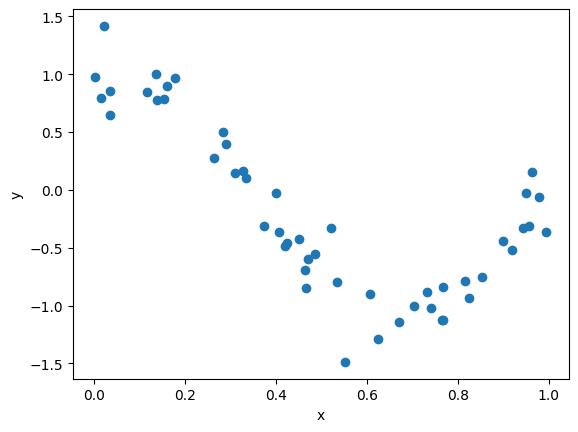

In [8]:
def f(x):
  return np.cos(1.5 * np.pi * x)

def generate_data(n_samples, seed=12):
  np.random.seed(seed=seed)
  # sample points
  X = np.random.rand(n_samples)

  # apply function
  y = f(X)

  # add noise
  y = y + np.random.randn(n_samples) * 0.2 # multiply by standard deviation (sigma)
  return X, y

X, y = generate_data(50)

plt.scatter(X, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Note that there is only one feature so X will be one dimensional.

##### **2) Define your train/test split**

First step is splitting the data into a train set and test set. The test set will be use to evaluate the generalization performance of the model and should at no point be seen by the model during learning.

`sklearn` provides a utility, [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split), that splits arrays into random train and test subsets. We will hold out 30% of the data for testing.

Total number of samples: 50
Number of training samples: 35
Number of testing samples: 15


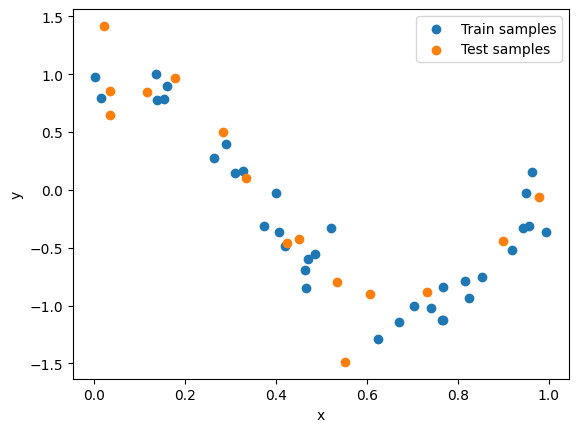

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('Total number of samples:', len(X))
print('Number of training samples:', len(X_train))
print('Number of testing samples:', len(X_test))

plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Train samples', 'Test samples'])
plt.show()

##### **3) Fit a model on the training data**

We consider a simple model, we can perform linear regression to approximate function `f`. The model will look like this:

$$\hat f(x) = w_0 + w_1 x$$

In [10]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train.reshape(-1, 1), y_train)  # X_train is reshape because reg expects a matrix of size (num_samples, num_feats)

LinearRegression()

Let's visualize the fitted model

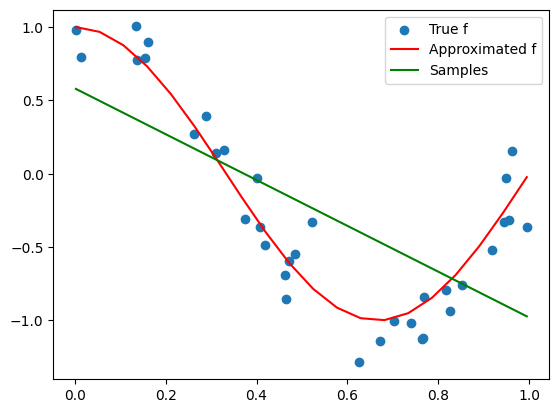

In [11]:
# plot data
plt.scatter(X_train, y_train)

# plot true function
x_grid = np.linspace(X.min(), X.max(), 20)
plt.plot(x_grid, f(x_grid), c='red')

# plot approximate function
plt.plot(x_grid, reg.predict(x_grid.reshape(-1, 1)), c='green')

plt.legend(['True f', 'Approximated f', 'Samples'])
plt.show()

We can clearly see how the model (in green) is **underfitting** the true function (in red). This will be further reflected when we evaluate the train and test errors.

Compute the error (loss) on our training and test set.

In [12]:
def compute_mean_squared_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

print('Train error:', compute_mean_squared_error(reg.predict(X_train.reshape(-1, 1)), y_train))
print('Test error:', compute_mean_squared_error(reg.predict(X_test.reshape(-1, 1)), y_test))

Train error: 0.23727210702186058
Test error: 0.3289274505694702


The model performs poorly on both sets.

##### **4) Increase the complexity of the features in the model**

The next step in this case is to use a more complex model, with potentially more parameters. We can perform **polynomial regression**!

A third-order polynomial, for example, will have the following formula:

$$\hat f(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3$$

`sklearn` does not provide a PolynomialRegression class unfortunately, but, by computing polynomial features, we can use `LinearRegression`. This is done as follows: X contains one feature of value $x_i$ for each of its $n$ samples. We add polynomial features (up to the desired degree, here 3) as new features of X:

$$
X = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n \\
\end{bmatrix}
\Longrightarrow
\begin{bmatrix}
x_1 & x_1^2 & x_1^3 \\
x_2 & x_2^2 & x_2^3\\
\vdots \\
x_n & x_n^2 & x_n^3\\
\end{bmatrix}
$$

In [13]:
def add_polynomial_features(x, deg):
    feats = []
    for i in range(1, deg+1):
        feats.append(x ** i)
    return np.vstack(feats).T

X_train_poly = add_polynomial_features(X_train, deg=3)
X_test_poly = add_polynomial_features(X_test, deg=3)

print('The data is now of shape', X_train_poly.shape, 'and has', X_train_poly.shape[1], 'features.')

The data is now of shape (35, 3) and has 3 features.


We can now perform polynomial regression using `LinearRegression`.

In [14]:
polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)

LinearRegression()

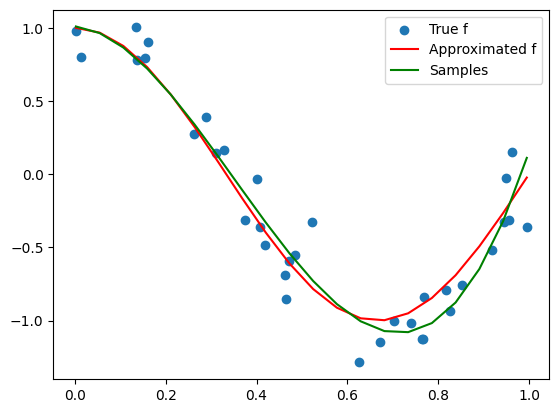

In [15]:
# plot data
plt.scatter(X_train, y_train)

# plot true function
x_grid = np.linspace(X.min(), X.max(), 20)
plt.plot(x_grid, f(x_grid), c='red')

# plot approximate function
x_grid_poly = add_polynomial_features(x_grid, deg=3)
plt.plot(x_grid, polyreg.predict(x_grid_poly), c='green')

plt.legend(['True f', 'Approximated f', 'Samples'])
plt.show()

The model already looks better, let's look at the errors.

In [16]:
print('Train error:', compute_mean_squared_error(polyreg.predict(X_train_poly), y_train))
print('Test error:', compute_mean_squared_error(polyreg.predict(X_test_poly), y_test))

Train error: 0.0332146064103495
Test error: 0.06620695904772293


The performance indeed improved a lot!
But can we do better? Let's give our model more parameters, let's use a polynomial of degree 8.

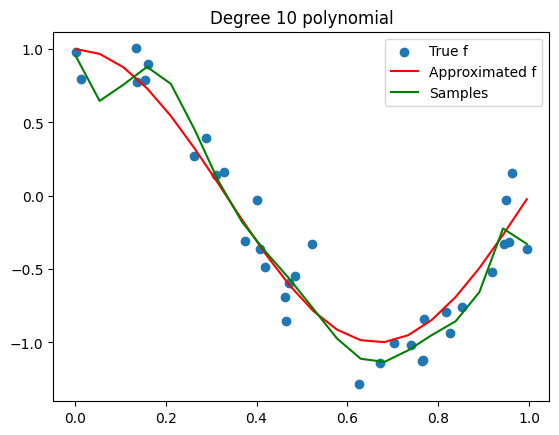

Train error: 0.022092160394082322
Test error: 0.06286758055951722


In [17]:
def fit_polynomial(X_train, y_train, X_test, y_test, deg, plot=False):
    X_train_poly = add_polynomial_features(X_train, deg=deg)
    X_test_poly = add_polynomial_features(X_test, deg=deg)

    polyreg = LinearRegression()
    polyreg.fit(X_train_poly, y_train)

    train_error = compute_mean_squared_error(polyreg.predict(X_train_poly), y_train)
    test_error = compute_mean_squared_error(polyreg.predict(X_test_poly), y_test)

    if plot:
        # plot data
      plt.scatter(X_train, y_train)

      # plot true function
      x_grid = np.linspace(X.min(), X.max(), 20)
      plt.plot(x_grid, f(x_grid), c='red')

      # plot approximate function
      x_grid_poly = add_polynomial_features(x_grid, deg=deg)
      plt.plot(x_grid, polyreg.predict(x_grid_poly), c='green')

      plt.legend(['True f', 'Approximated f', 'Samples'])
      plt.title('Degree %d polynomial' %deg)
      plt.show()
    return train_error, test_error

train_error, test_error = fit_polynomial(X_train, y_train, X_test, y_test, deg=10, plot=True)
print('Train error:', train_error)
print('Test error:', test_error)

The model now looks more complex, the red curve passes through most training samples, but no longer matches the true function well. While the train error decreases, the test error starts increasing significatly: the model is **overfitting**.

### 4. Model selection: Validation set

Now that we have seen three different models, how do we proceed to find the appropriate number of parameters or complexity of our model?

One commonly used approach for model selection is defining a set for validation to tune hyperparameters over. We can simulate a "test" set by holding out a few samples from the train set, to create what is called a **validation** set. It is used for hyperparameter tuning (in this case, we need to tune the degree of the polynomial) and acts as a surrogate for the test set.


Let's transform 20% of the training samples to validation samples. The rest of the 80% of the training set will be used to train the model.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print('Number of remaining training samples:', len(X_train))
print('Number of validation samples:', len(X_val))

Number of remaining training samples: 28
Number of validation samples: 7


We compute errors for different degrees, this allows us to draw the **training curve** and the **validation curve**.

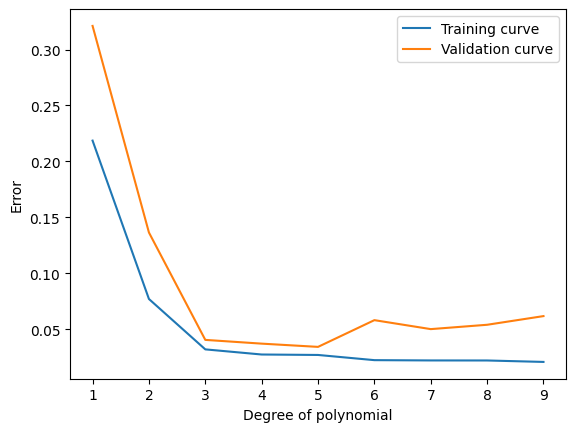

In [19]:
train_errors, val_errors = [], []
deg_range = range(1, 10)
for deg in deg_range:
  train_error, val_error = fit_polynomial(X_train, y_train, X_val, y_val, deg=deg)
  train_errors.append(train_error)
  val_errors.append(val_error)

plt.plot(deg_range, train_errors)
plt.plot(deg_range, val_errors)
plt.legend(['Training curve', 'Validation curve'])
plt.xlabel('Degree of polynomial')
plt.ylabel('Error')
plt.show()

We see that after increasing the degree of the polynomial beyond 5, the model starts overfitting the data. Thus, a 5-degree polynomial would be appropriate.



Now we can specify our final model.

Train error: 0.02693904397037586
Test error: 0.05906137955210001


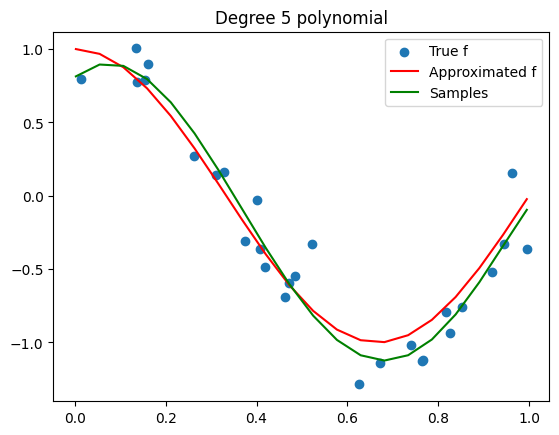

In [20]:
deg = 5

X_train_poly = add_polynomial_features(X_train, deg=deg)
X_test_poly = add_polynomial_features(X_test, deg=deg)

polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)

print('Train error:', compute_mean_squared_error(polyreg.predict(X_train_poly), y_train))
print('Test error:', compute_mean_squared_error(polyreg.predict(X_test_poly), y_test))

# plot data
plt.scatter(X_train, y_train)

# plot true function
x_grid = np.linspace(X.min(), X.max(), 20)
plt.plot(x_grid, f(x_grid), c='red')

# plot approximate function
x_grid_poly = add_polynomial_features(x_grid, deg=deg)
plt.plot(x_grid, polyreg.predict(x_grid_poly), c='green')

plt.legend(['True f', 'Approximated f', 'Samples'])
plt.title('Degree %d polynomial' %deg)
plt.show()

### 5. Interpolation vs. Extrapolation

In general, machine learning models can **only** interpolate. There are possible exceptions, but this requires some specialized model development and/or prior knowledge of the nature of the model.

If, for example, we extend the domain definition of our previous function $f$ to from $x\in[0, 1]$ to  $x\in[-1, 2]$, we will see how the model fails to extrapolate outside of the range it was trained on.

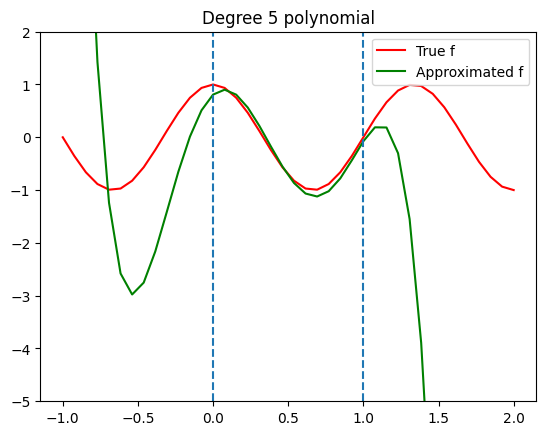

In [21]:
# plot true function
x_grid = np.linspace(-1, 2, 40)
plt.plot(x_grid, f(x_grid), c='red')

# plot approximate function
x_grid_poly = add_polynomial_features(x_grid, deg=deg)
plt.plot(x_grid, polyreg.predict(x_grid_poly), c='green')

plt.legend(['True f', 'Approximated f'])
plt.title('Degree %d polynomial' %deg)
plt.ylim([-5, 2])
plt.vlines([0, 1], -5, 2, linestyles='dashed')
plt.show()


"Extrapolation" with machine learning models is typically achieved through search/exploration algorithms or "adaptive learning". These algorithms utilize machine-learning models to produce an iterative experimental design scheme that involves collection of new data. This effectively turns extrapolation problems into interpolation problems.

**Challenge:**

1. Randomly assigning samples into a training and test split is the most common approach for cross-validation. Describe at least three of the other evaluation approaches and why they may be useful for different biomedical applications.

>

2. In which scenarios is random sampling no longer sufficient?

>

*Add your responses here:*

> Reply here



**Additional resources:**

- Distill article on momentum: https://distill.pub/2017/momentum/
- Overview on cross-validation here: https://scikit-learn.org/stable/modules/cross_validation.html

**Tutorials and related concepts in sklearn:**
- Visualizing cross-validation behavior: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
- Comparing various optimizers: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_comparison.html#sphx-glr-auto-examples-linear-model-plot-sgd-comparison-py

Contributors: Mehdi Azabou, Eva Dyer, AJ Medford. Some examples adapted from materials from COE 3803 taught by EL Dyer and AJ Medford.